In [12]:
import sys
import os
import glob 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sc

import plotly.express as px
import plotly.graph_objects as go

import collections

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [5]:
derived_path = "/cluster/home/taoj/work_dir/eth-capstone/tree-water-deficit/data"
data_dir = "/cluster/home/taoj/work_dir/eth-caipstone/tree-water-deficit/data/tstoy04"

In [7]:
df_series_all = pd.read_csv(os.path.join(derived_path, "twd_tree_series_all.csv"))
twd_tree_series_sites = pd.read_csv(os.path.join(derived_path, "twd_tree_series_sites.csv"))

In [9]:
df_series_all.head(10)
# twd_tree_series_sites.head(10)

,ts,twd,pr,at,ws,dp,sr,lr,series,site_name,species,series_no,Wt,year,month,year_month
0,2020-01-01,0.000000,-4.967054e-09,0.684757,1.197186,-3.640214,62.291590,212.325577,series_06,Bachtel-Forest,Fagus sylvatica,1,NaN,2020,1,2020-01
1,2020-01-02,0.121408,-1.092752e-07,0.213088,1.312338,-4.036302,60.923900,219.828021,series_06,Bachtel-Forest,Fagus sylvatica,1,0.121408,2020,1,2020-01
2,2020-01-03,0.118271,1.285767e-01,2.009851,2.115951,-0.953911,55.859708,275.925156,series_06,Bachtel-Forest,Fagus sylvatica,1,-0.003137,2020,1,2020-01
3,2020-01-04,0.000000,9.927122e-02,1.573278,3.247398,0.721803,13.914832,311.878969,series_06,Bachtel-Forest,Fagus sylvatica,1,-0.118271,2020,1,2020-01
4,2020-01-05,0.000000,-1.986821e-08,-0.442240,2.159941,-4.094125,62.620516,216.038632,series_06,Bachtel-Forest,Fagus sylvatica,1,0.000000,2020,1,2020-01
5,2020-01-06,0.000000,3.880511e-10,1.900865,1.479226,-5.472837,63.572741,220.306782,series_06,Bachtel-Forest,Fagus sylvatica,1,0.000000,2020,1,2020-01
6,2020-01-07,0.593406,2.411429e-02,1.480216,2.514120,-1.105571,26.014536,265.315427,series_06,Bachtel-Forest,Fagus sylvatica,1,0.593406,2020,1,2020-01
7,2020-01-08,0.557187,-6.457170e-07,3.140700,2.099829,-7.224881,48.464034,265.264362,series_06,Bachtel-Forest,Fagus sylvatica,1,-0.036220,2020,1,2020-01
8,2020-01-09,0.918142,-1.182159e-06,5.119999,1.631017,-5.251706,58.383674,248.506977,series_06,Bachtel-Forest,Fagus sylvatica,1,0.360955,2020,1,2020-01
9,2020-01-10,1.269509,5.132516e-03,3.655803,3.022984,-0.587912,39.215077,289.792323,series_06,Bachtel-Forest,Fagus sylvatica,1,0.351367,2020,1,2020-01


start from simple model 
- understand the covariance, mean a little better
- gaussian process
- autoregressive model 

1. autoregressive

Augmented Dickey-Fuller Test table
https://support.minitab.com/en-us/minitab/help-and-how-to/statistical-modeling/time-series/how-to/augmented-dickey-fuller-test/interpret-the-results/all-statistics-and-graphs/

In [43]:
df_series_1 = df_series_all.loc[(df_series_all.series_no == 1) & (df_series_all.year == 2020), ]
result = adfuller(df_series_1["twd"], autolag = 'AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.2298507542951334
p-value: 0.19559025445301198
Critial Values:
   1%, -3.4491725955218655
Critial Values:
   5%, -2.8698334971428574
Critial Values:
   10%, -2.5711883591836733


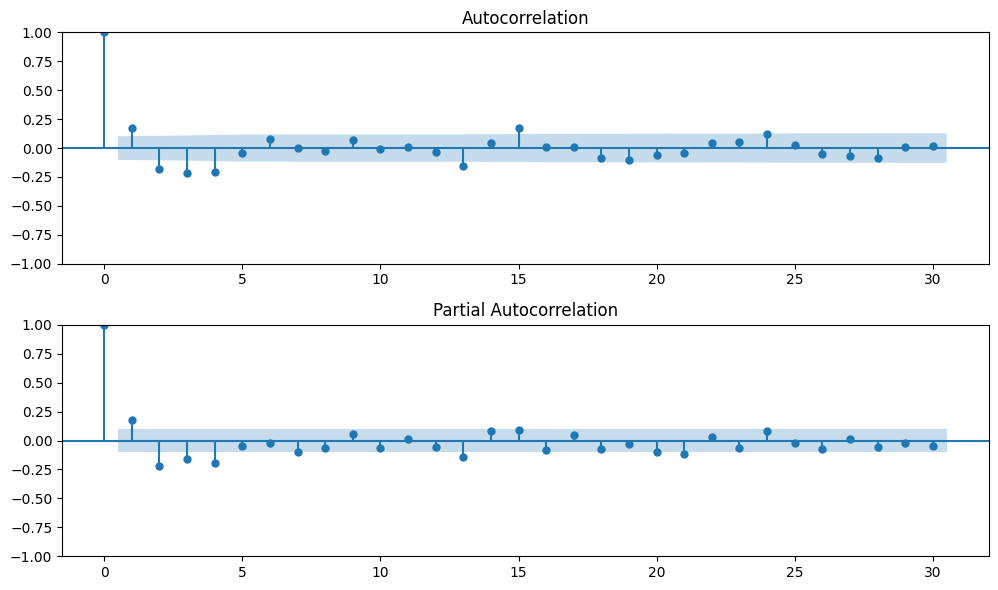

In [28]:
df_diff = df_series_1["twd"].diff().dropna()
fig, ax = plt.subplots(2,1, figsize=(10,6))
plot_acf(df_diff, lags=30, ax=ax[0])
plot_pacf(df_diff, lags=30, ax=ax[1])
plt.tight_layout()
plt.show()

it seems the lag can be 13... 

data preparation

In [38]:

# Psudotsuga mnzisii", the same site "Multi-Forest" in 2021, 2022 exluded
df_series_all = df_series_all.loc[~((df_series_all.species == "Psudotsuga mnzisii") & (df_series_all.site_name == "Multi-Forest") & (df_series_all.year.isin([2021, 2022]))), ]
df_series_all_median = df_series_all.groupby(['site_name', 'species', 'ts']).agg({'twd': 'median',  'year': 'first',
                                                                                 'pr': 'median', 'at': 'median', "ws": 'median', 'dp': 'median',
                                                                                 'sr': 'median', 'lr':'median'}).reset_index() 

df_series_all_median= df_series_all_median.merge(twd_tree_series_sites[['site_name', 'species', 'mch_elevation', 'site_longitude', 'site_latitude']].drop_duplicates(), on=['site_name', 'species'], how='left')

In [55]:
# transform species to categorical variable - using ohe-hot encoding
# Get one hot encoding of columns B
one_hot = pd.get_dummies(df_series_all_median['species'],dtype=float)
# Drop column B as it is now encoded
df_series_all_features = df_series_all_median.drop('species',axis = 1)
# Join the encoded df
df_series_all_features = df_series_all_features.join(one_hot.iloc[: , 0:6])

In [56]:
df_series_all_features

,site_name,ts,twd,year,pr,at,ws,dp,sr,lr,mch_elevation,site_longitude,site_latitude,Carpinus betulus,Corylus avellana,Fagus sylvatica,Picea abies,Pinus sylvestris,Pseudotsuga menziesii
0,Bachtel-Forest,2020-01-01,0.000000,2020,-4.967054e-09,0.684757,1.197186,-3.640214,62.291590,212.325577,882.140575,8.89016,47.29413,0.0,0.0,1.0,0.0,0.0,0.0
1,Bachtel-Forest,2020-01-02,0.121408,2020,-1.092752e-07,0.213088,1.312338,-4.036302,60.923900,219.828021,882.140575,8.89016,47.29413,0.0,0.0,1.0,0.0,0.0,0.0
2,Bachtel-Forest,2020-01-03,0.118271,2020,1.285767e-01,2.009851,2.115951,-0.953911,55.859708,275.925156,882.140575,8.89016,47.29413,0.0,0.0,1.0,0.0,0.0,0.0
3,Bachtel-Forest,2020-01-04,0.000000,2020,9.927122e-02,1.573278,3.247398,0.721803,13.914832,311.878969,882.140575,8.89016,47.29413,0.0,0.0,1.0,0.0,0.0,0.0
4,Bachtel-Forest,2020-01-05,0.000000,2020,-1.986821e-08,-0.442240,2.159941,-4.094125,62.620516,216.038632,882.140575,8.89016,47.29413,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21915,Sihlwald-Forest,2022-12-27,0.003764,2022,7.890425e-02,4.010645,1.909832,2.355262,26.803715,290.990254,722.265575,8.56111,47.25056,0.0,0.0,1.0,0.0,0.0,0.0
21916,Sihlwald-Forest,2022-12-28,0.000000,2022,2.787872e-06,3.266429,2.896402,-0.281365,48.663056,245.492409,722.265575,8.56111,47.25056,0.0,0.0,1.0,0.0,0.0,0.0
21917,Sihlwald-Forest,2022-12-29,0.250309,2022,2.516162e-01,6.377938,3.076757,1.008028,37.025694,307.887946,722.265575,8.56111,47.25056,0.0,0.0,1.0,0.0,0.0,0.0
21918,Sihlwald-Forest,2022-12-30,0.106996,2022,4.619100e-01,5.292577,2.608761,3.574435,32.584284,311.814548,722.265575,8.56111,47.25056,0.0,0.0,1.0,0.0,0.0,0.0
